#Assessed Exercise for Deep Learning (M)

###Submitted by: Sheena Gaur
###2422748G

##Analysis of Problem

Many breeds of dogs and cats exist and sometimes people are unable to identify them just by looking. The problem that this classifier aims to solve is to correctly determine the breed of both dogs and cats from a given picture that have distinct differences between them. Such a classifier can be enhanced to be used in mobile applications to identify in real-time the breed of dog and cats pointed to with the help of the mobile's camera.

##Analysis of Data

In order to create such a model the following measures are taken:

*   The data set of dog and cat breeds is taken from http://www.robots.ox.ac.uk/~vgg/data/pets/ which is about 1600 images
*   The original data set contained images for 37 different breeds but for the purpose of this assignment only 8 are used.
* The breeds used are Abyssinian, Bengal, Birman, Bombay, American bulldog, American pit bull terrier, Basset hound and Beagle.
* These input images are divided into folders based on their breed wherein for each breed, approximately 200 images are used.
* For testing the model, random images are taken from Google (the rights of the images are with the original owners) and are used for prediction. About 44 images are used.
* All these images are in the JPEG format and are of varying size and contain the subject in different backgrounds, lighting and age.
* For the image classification, a pre-trained model is used. The **Resnet50** model is a pre-trained model is used for classification.

The Resnet50 model is a deep convolutional network that is pre-trained for image classification. Its use of multiple layers of convolution filters makes it a good choice to use for image classification.

The images are imported using a Dropbox URL and are then divided into training, validation and test sets.


In [0]:
#@title Initial imports for the classifier
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [0]:
#@title Importing images and dividing the data into training and validation sets

# Code taken from sample code provided for exercise.
# Data taken from http://www.robots.ox.ac.uk/~vgg/data/pets/
DOGCAT_DIR = './images_folder'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018
def download_images():
  if not os.path.exists(DOGCAT_DIR):
    DOWNLOAD_URL = 'https://www.dropbox.com/s/yb2btd4tn0lef0e/images_folder.tar'
    print('Downloading dog_cat images from %s...' % DOWNLOAD_URL)
    if not os.path.isfile('./images_folder.tar'):
      !wget https://www.dropbox.com/s/yb2btd4tn0lef0e/images_folder.tar
      !tar xf images_folder.tar
  print('Dog_Cat photos are located in %s' % DOGCAT_DIR)

download_images()
if not os.path.exists('./dog_cat'):
    os.mkdir('./dog_cat')


image_dir = DOGCAT_DIR
from sklearn.model_selection import train_test_split

# Read all flower images (.jpg) from a folder
# The function returns both the path of the flower image and the corresponding label
# which is defined by the name of the foler in which the image is
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    
    labels = []
    images = []
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        labels_folder, images_folder = read_images_from_dir(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_images(image_dir)


# Split the data into test and training sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

# Create folders for test and training that can be passed to Keras Generators
train_folder = './dog_cat/output/train'
test_folder  = './dog_cat/output/test'
output_folder = './dog_cat/output'

def create_output_folders():
    if not os.path.exists(output_folder):
        print('Creating output directories')
        os.mkdir(output_folder)
        if not os.path.exists(train_folder):
            os.mkdir(train_folder)
            for label in set(labels):
                os.mkdir(train_folder + '/' + label)
        if not os.path.exists(test_folder):
            os.mkdir(test_folder)
            for label in set(labels):
                os.mkdir(test_folder + '/' + label)

def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
        dest = os.path.join(train_folder, labels_train[index])
        shutil.copy(value, dest)

    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
        shutil.copy(value, test_folder + '/' + labels_test[index])
        
create_output_folders()
copy_files_to_train_and_validation_folders()

--2019-03-03 17:23:26--  https://www.dropbox.com/s/yb2btd4tn0lef0e/images_folder.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yb2btd4tn0lef0e/images_folder.tar [following]
--2019-03-03 17:23:27--  https://www.dropbox.com/s/raw/yb2btd4tn0lef0e/images_folder.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc51571a1a25b5ab8c6c455aa92a.dl.dropboxusercontent.com/cd/0/inline/AcZ2BSVI3WOa46Ok4e6V7ueV60gPXwLlWVm0KfExBxfsHT3AcDI3wD8_bdbh7telAKeskHj0Z1IZv6k82BU5EeeKHMo4fL3wKNjDmyx4QWw-Gg/file# [following]
--2019-03-03 17:23:27--  https://uc51571a1a25b5ab8c6c455aa92a.dl.dropboxusercontent.com/cd/0/inline/AcZ2BSVI3WOa46Ok4e6V7ueV60gPXwLlWVm0KfExBxfsHT3AcDI3wD8_bdbh7telAKeskHj0Z1IZv6k82BU5EeeKHMo4fL3wKNjDmyx4QWw-Gg/file
Reso

As Resnet50 is being used as a classifier, not much image pre-processing was required. The images are refitted to the size of 224 as that is the size expected by Resnet50. The keras implementation of Resnet50 includes an image preprocessing function which is  preprocess_input. This is supplied as the function to ImageDataGenerator.

In [0]:
#@title Image Pre-processing.
# Pre-process the images using keras ImageDataGenerator. The image pre-procesor used is ResNet50 image pre-processor as the Resnet50 is the classification model used.
image_size = 224 # Image ize used by Resnet50
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator      = data_generator.flow_from_directory(train_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(test_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')

Found 1118 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


In [0]:
# labels for the breeds found in the input data.
train_fnames = os.listdir(train_folder)
print(train_fnames[:])

['beagle', 'Abyssinian', 'Bengal', 'american_pit_bull_terrier', 'Bombay', 'american_bulldog', 'Birman', 'basset_hound']


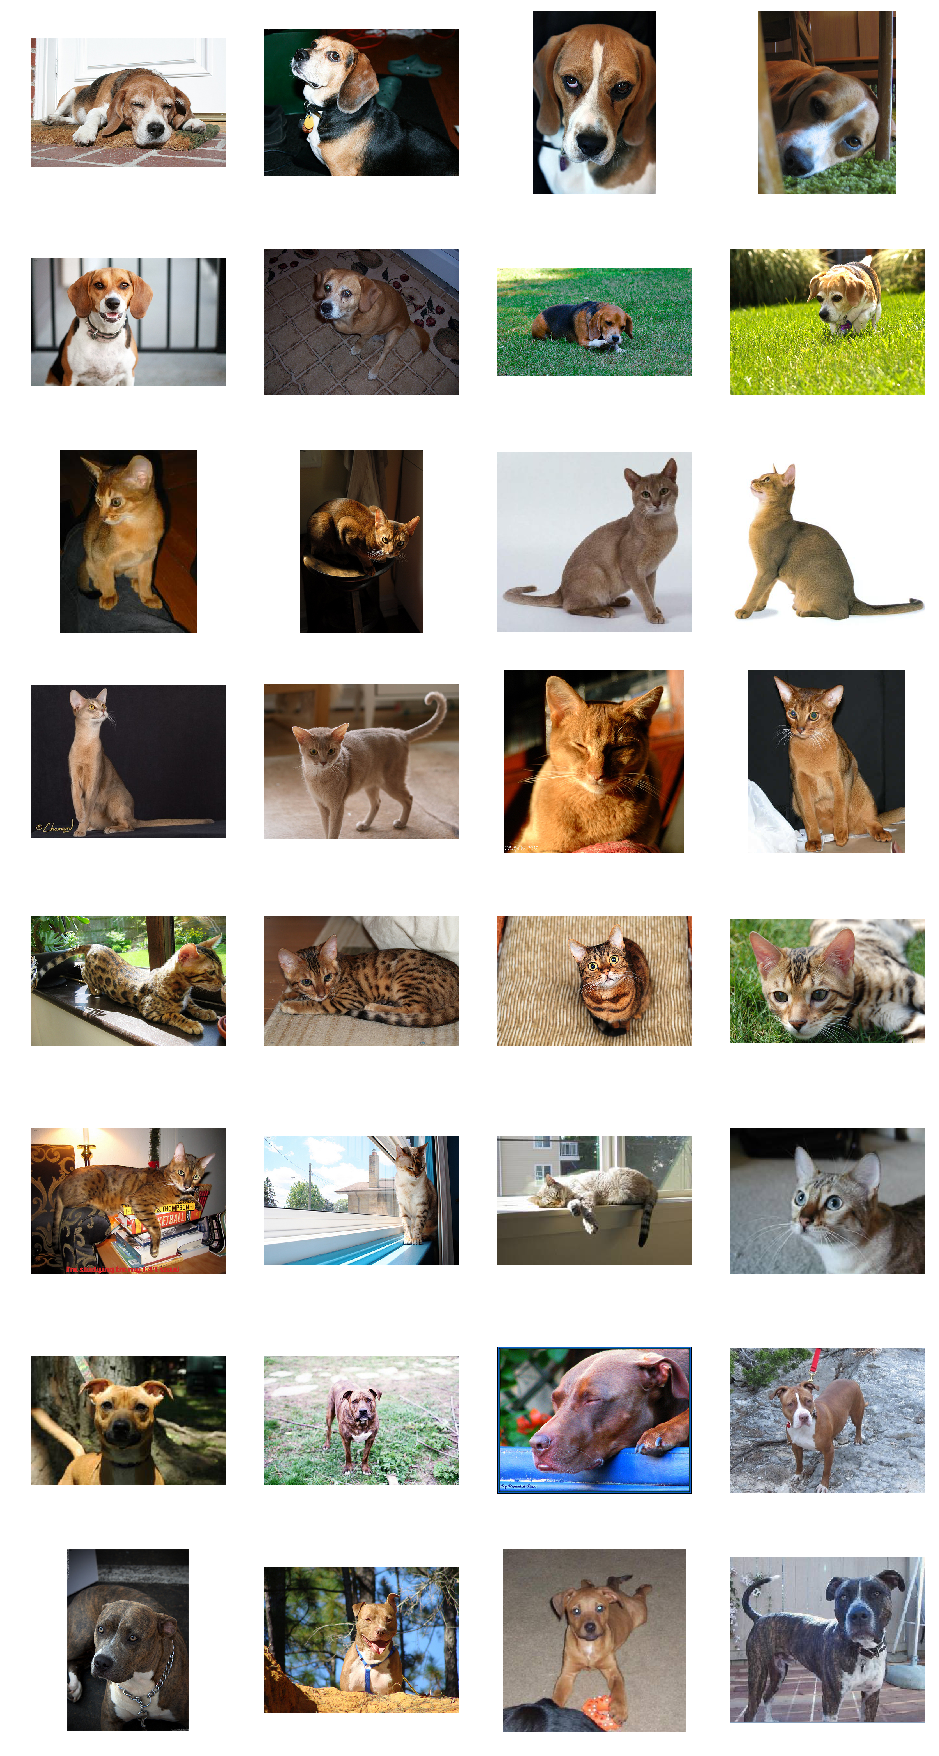

In [0]:
#@title Sample of input data taken from Bengal, Beagle, Abyssinian, Birman breeds
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 16x4 configuration
nrows = 16
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_pix = []
for i in range(0,len(train_fnames)-4):
  foldername = os.listdir(train_folder+"/"+train_fnames[i])
  for fname in foldername[pic_index-8:pic_index]:
    next_pix.append(os.path.join(train_folder+"/"+train_fnames[i], fname))

for j, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, j + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

As can be seen from the training images, the subjects can be seen in varying backgrounds, lightning and age. This allows the classifier to recognise the breed from the test set even with some noise.

## Training the Model using Resnet50

In [0]:
#@title Model0- Training the selected model

from tensorflow.python.keras.callbacks import EarlyStopping

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

lamb = 0.001

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'] )

# train the model on the new data for a few epochs
history_1 =model.fit_generator(train_generator,steps_per_epoch=10,epochs = 20, validation_data=validation_generator,validation_steps=10)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/20
10/10 [==============================] - 48s 5s/step - loss: 1.7590 - acc: 0.3625 - val_loss: 1.0015 - val_acc: 0.6875
Epoch 2/20
10/10 [==============================] - 4s 420ms/step - loss: 0.8799 - acc: 0.7042 - val_loss: 0.6366 - val_acc: 0.7958
Epoch 3/20
10/10 [==============================] - 4s 413ms/step - loss: 0.7082 - acc: 0.7911 - val_loss: 0.4263 - val_acc: 0.8625
Epoch 4/20
10/10 [==============================] - 4s 423ms/step - loss: 0.5229 - acc: 0.8167 - val_loss: 0.3951 - val_acc: 0.8583
Epoch 5/20
10/10 [==============================] - 4s 421ms/step - loss: 0.5021 - acc: 0.8625 - val_loss: 0.2948 - val_acc: 0.9083
Epoch 6/20
10/10 [==============================] - 4s 421ms/step - loss: 0.4403 - acc: 0.8667 - val_loss: 0.3443 - val_acc: 0.8667
Epoch 7/20
10/10 [==============================] - 4s 420ms/step - loss: 0.3927 - acc: 0.8667 - val_loss: 0.2663 - val_acc: 0.9083
Epoch 8/20
10/10 [==============================] - 4s 413ms/step - loss: 0.29

In [0]:
# A summary of the model used.
model.save('cats_and_dogs_types.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

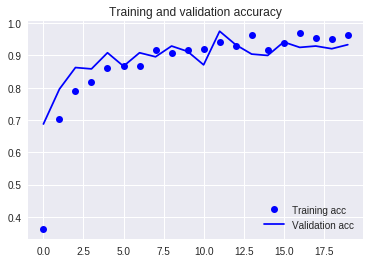

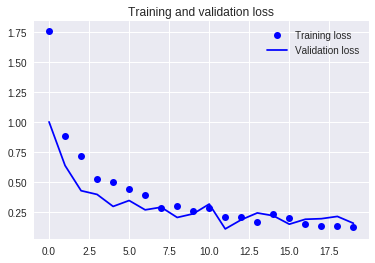

In [0]:
#@title Performace Measurement in term of loss and accuracy.

import matplotlib.pyplot as plt

acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

With only 20 epoch having 10 steps each, the model has shown very good performance. The validation accuracy is ~93% whereas the loss is ~0.15. This model only uses the topmost layers of Resnet50 and is yielding very good performance. If the lower layers are unfrozen, the performance drops considerably. This is the selected model that will be used for final testing of the data. As will be seen in the next section, this model has better accuracy and loss for the validation data than the other models selected.

##Comparision with different Models

In [0]:
#@title Model1-Using a basic model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)             0         
__________

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_baseline = train_datagen.flow_from_directory(
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator_baseline = test_datagen.flow_from_directory(
        test_folder,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)

Found 1118 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


In [0]:
#@title Training the basic model
history_0 = model.fit_generator(
      train_generator_baseline,
      steps_per_epoch=10,
      epochs=30,
      validation_data=validation_generator_baseline,
      validation_steps=10)

Epoch 1/30
10/10 [==============================] - 43s 4s/step - loss: 2.5250 - acc: 0.1700 - val_loss: 2.0680 - val_acc: 0.1450
Epoch 2/30
10/10 [==============================] - 1s 138ms/step - loss: 2.0677 - acc: 0.1950 - val_loss: 2.0580 - val_acc: 0.1550
Epoch 3/30
10/10 [==============================] - 2s 190ms/step - loss: 2.0732 - acc: 0.1500 - val_loss: 2.0451 - val_acc: 0.1850
Epoch 4/30
10/10 [==============================] - 2s 179ms/step - loss: 2.0177 - acc: 0.2150 - val_loss: 2.0397 - val_acc: 0.1650
Epoch 5/30
10/10 [==============================] - 2s 188ms/step - loss: 1.9985 - acc: 0.2350 - val_loss: 1.9158 - val_acc: 0.2550
Epoch 6/30
10/10 [==============================] - 2s 181ms/step - loss: 1.8642 - acc: 0.2813 - val_loss: 1.7771 - val_acc: 0.3450
Epoch 7/30
10/10 [==============================] - 2s 182ms/step - loss: 1.7281 - acc: 0.4000 - val_loss: 1.7435 - val_acc: 0.3450
Epoch 8/30
10/10 [==============================] - 2s 184ms/step - loss: 1.72

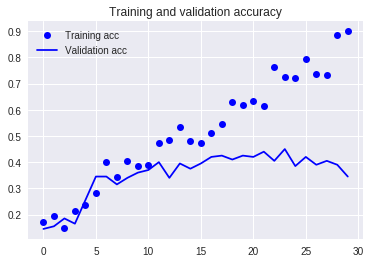

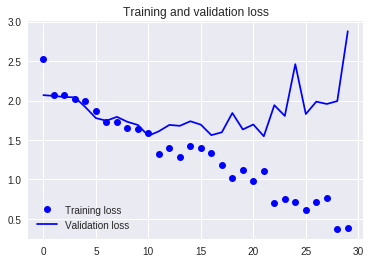

In [0]:
#@title Change in training/validation loss and accuracy.
acc = history_0.history['acc']
val_acc = history_0.history['val_acc']
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

For a basic model is created with three convolution layers and one dense layer at the end. This models serve as a baseline for all other models and can be used to check the performance of the Resnet50 model with different hyperparameters. The performance of the basic model is not very good. Even though the training accuracy and loss are very good but the validation loss increases to about 2.8 and the accuracy drops to ~35%. When the same data is provided to the Resnet50 model using only the topmost layers, it gives a much better performance.



In [0]:
#@title Model2 -Unfreezing lower layers of Resnet50 and freezing top layers and using SGD as optimizer
from keras.models import load_model

model = load_model('cats_and_dogs_types.h5') 

# if we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hitory_2 = model.fit_generator(train_generator,steps_per_epoch=10,epochs = 20, validation_data=validation_generator,validation_steps=10)

Epoch 1/20
10/10 [==============================] - 53s 5s/step - loss: 0.1263 - acc: 0.9555 - val_loss: 0.1551 - val_acc: 0.9333
Epoch 2/20
10/10 [==============================] - 4s 422ms/step - loss: 0.0988 - acc: 0.9750 - val_loss: 0.1447 - val_acc: 0.9417
Epoch 3/20
10/10 [==============================] - 4s 423ms/step - loss: 0.1009 - acc: 0.9667 - val_loss: 0.2223 - val_acc: 0.9208
Epoch 4/20
10/10 [==============================] - 4s 427ms/step - loss: 0.1124 - acc: 0.9708 - val_loss: 0.1456 - val_acc: 0.9458
Epoch 5/20
10/10 [==============================] - 4s 429ms/step - loss: 0.1151 - acc: 0.9708 - val_loss: 0.2197 - val_acc: 0.9250
Epoch 6/20
10/10 [==============================] - 4s 418ms/step - loss: 0.1095 - acc: 0.9707 - val_loss: 0.1861 - val_acc: 0.9292
Epoch 7/20
10/10 [==============================] - 4s 423ms/step - loss: 0.1222 - acc: 0.9583 - val_loss: 0.1394 - val_acc: 0.9458
Epoch 8/20
10/10 [==============================] - 4s 427ms/step - loss: 0.09

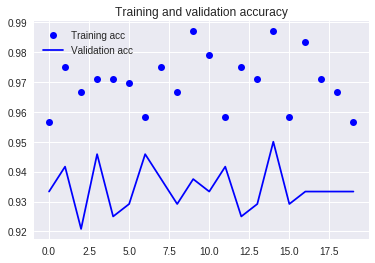

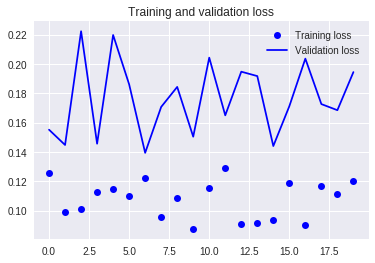

In [0]:
#@title Change in training/validation loss and accuracy.
acc = hitory_2.history['acc']
val_acc = hitory_2.history['val_acc']
loss = hitory_2.history['loss']
val_loss = hitory_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As can be seen from the graphs, the training and validation loss is very erratic whereas the validation accuracy has dropped to ~93%. Also, the loss increases to ~0.19. As there is a decrease in performance and an increase in loss, this model is not used. It is better than the basic model. This model still does not perform better than the first model selected as the main classification model, even though it varies only by a small margin. Increasing the number of layers not only increases the complexity of the model but in no way improves the model. This goes to show that a large volume of layers does not always mean an increase in accuracy.

In [0]:
#@title Model3- Using SGD on the topmost layers instead of RMProp Optimizer.

model = Model(inputs=base_model.input, outputs=predictions)

# Reset the model to train only top layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'] )

# train the model on the new data for a 20 epochs
history_3 =model.fit_generator(train_generator,steps_per_epoch=10,epochs = 20, validation_data=validation_generator,validation_steps=10)


Epoch 1/20
10/10 [==============================] - 53s 5s/step - loss: 0.1156 - acc: 0.9583 - val_loss: 0.1766 - val_acc: 0.9375
Epoch 2/20
10/10 [==============================] - 4s 422ms/step - loss: 0.0960 - acc: 0.9792 - val_loss: 0.1675 - val_acc: 0.9292
Epoch 3/20
10/10 [==============================] - 4s 422ms/step - loss: 0.1108 - acc: 0.9667 - val_loss: 0.1933 - val_acc: 0.9333
Epoch 4/20
10/10 [==============================] - 4s 415ms/step - loss: 0.0823 - acc: 0.9833 - val_loss: 0.1620 - val_acc: 0.9458
Epoch 5/20
10/10 [==============================] - 4s 420ms/step - loss: 0.1279 - acc: 0.9708 - val_loss: 0.1697 - val_acc: 0.9333
Epoch 6/20
10/10 [==============================] - 4s 419ms/step - loss: 0.0805 - acc: 0.9833 - val_loss: 0.1307 - val_acc: 0.9458
Epoch 7/20
10/10 [==============================] - 4s 415ms/step - loss: 0.0994 - acc: 0.9792 - val_loss: 0.1971 - val_acc: 0.9250
Epoch 8/20
10/10 [==============================] - 4s 409ms/step - loss: 0.09

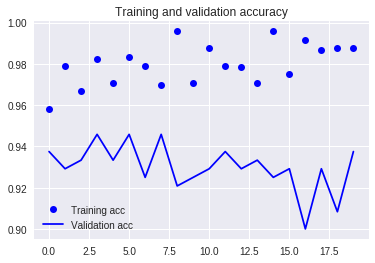

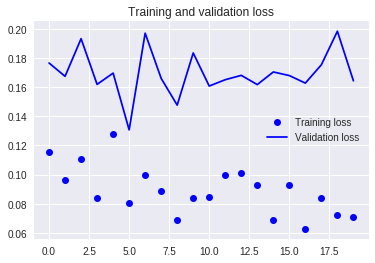

In [0]:
#@title Change in training/validation loss and accuracy.
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As can be seen from the graphs, as was the case of the previous test, the validation accuracy has dropped to ~93%. Also, the validation loss increases to ~0.17. As compared to the selected model there is a decrease in performance and an increase in loss, this model is not used. The performance of SGD model is not better than the first model selected.

## Testing  the selected model

In [0]:
#@title Reload the selected model
# Reseting the model to the best result yielding one.

model = load_model('cats_and_dogs_types.h5') 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Method to get breed text from breed number
import numpy as np

def getBreedFromNumber(breedNumber):
  breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'American bulldog', 'American pit bull terrier', 'Basset hound', 'Beagle']
  if isinstance(breedNumber, np.int64):
    return breeds[breedNumber]
  breedlist = [breeds[num] for num in breedNumber]
  return breedlist

In [0]:
#@title Predicting the breed of three individual images
# Using single images taken from Google

# The local path to our target image
!wget "https://www.dropbox.com/s/22rxn2po57zj5iz/the-american-pit-bull-terrier_test.jpg"
test_img_path = 'the-american-pit-bull-terrier_test.jpg'

!wget "https://www.dropbox.com/s/c84e7o8dob09u8v/600-bombay-in-chair.jpg"
test2_img_path = '600-bombay-in-chair.jpg'

!wget "https://www.dropbox.com/s/fsdndcp2jx8dzum/beagle.jpg"
test3_img_path = 'beagle.jpg'

test_img = image.load_img(test_img_path, target_size=(image_size, image_size))
test2_img = image.load_img(test2_img_path, target_size=(image_size, image_size))
test3_img = image.load_img(test3_img_path, target_size=(image_size, image_size))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(test_img)
x2 = image.img_to_array(test2_img)
x3 = image.img_to_array(test3_img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
x2 = np.expand_dims(x2, axis=0)
x3 = np.expand_dims(x3, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)
x2 = preprocess_input(x2)
x3 = preprocess_input(x3)

--2019-03-03 18:02:29--  https://www.dropbox.com/s/22rxn2po57zj5iz/the-american-pit-bull-terrier_test.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/22rxn2po57zj5iz/the-american-pit-bull-terrier_test.jpg [following]
--2019-03-03 18:02:29--  https://www.dropbox.com/s/raw/22rxn2po57zj5iz/the-american-pit-bull-terrier_test.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb6abebf9e22a32fe68ba8b2c4.dl.dropboxusercontent.com/cd/0/inline/AcYoEzgZ7snGTCYCk4kxpyhqJ_hJxu6-iSsIot51-p-uYtnXz0frO1YbYlUOJY7G3LJd3KBJ2RofYw0GS3b3WNlKHhtXbcofjId1L2P63qPtyQ/file# [following]
--2019-03-03 18:02:29--  https://uccb6abebf9e22a32fe68ba8b2c4.dl.dropboxusercontent.com/cd/0/inline/AcYoEzgZ7snGTCYCk4kxpyhqJ_hJxu6-iSsIot51-p-uYtnXz0frO1YbY

In [0]:
# call the predict method of the model.
preds = model.predict(x)
preds2 = model.predict(x2)
preds3 = model.predict(x3)

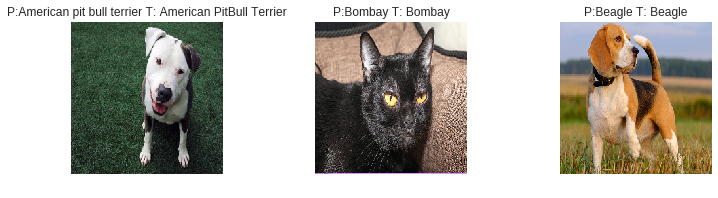

In [0]:
#@title Show the images and their predictions.
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,3,1)
ax.axis('off')
ax.grid(False)
ax.set_title('P:'+getBreedFromNumber(np.argmax(preds[0]))+' T: American PitBull Terrier')
ax.imshow(image.img_to_array(test_img)/255.)
ax = fig.add_subplot(1,3,2)
ax.axis('off')
ax.grid(False)
ax.set_title('P:'+getBreedFromNumber(np.argmax(preds2[0]))+' T: Bombay')
ax.imshow(image.img_to_array(test2_img)/255.)
ax = fig.add_subplot(1,3,3)
ax.axis('off')
ax.grid(False)
ax.set_title('P:'+getBreedFromNumber(np.argmax(preds3[0]))+' T: Beagle')
ax.imshow(image.img_to_array(test3_img)/255.)

fig.tight_layout()

In the individual image classification, the model correctly identified all three images. As the verification of the model is complete for a very small set of data, it can now be tested on a large tet set.

In [0]:
#@title Loading the test Images.There are 44 images in total from all 8 breeds.
TEST_DIR = './test_folder'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018
def download_images():
  if not os.path.exists(TEST_DIR):
    DOWNLOAD_URL = 'https://www.dropbox.com/s/rprrhrkypnp46a5/test_folder.tar'
    print('Downloading dog_cat images from %s...' % DOWNLOAD_URL)
    if not os.path.isfile('./test_folder.tar'):
      !wget https://www.dropbox.com/s/rprrhrkypnp46a5/test_folder.tar
      !tar xf test_folder.tar
  print('Test images are located in %s' % TEST_DIR)

download_images()

--2019-03-03 18:06:33--  https://www.dropbox.com/s/rprrhrkypnp46a5/test_folder.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rprrhrkypnp46a5/test_folder.tar [following]
--2019-03-03 18:06:33--  https://www.dropbox.com/s/raw/rprrhrkypnp46a5/test_folder.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27bc593b5705f32ba77378c1e6.dl.dropboxusercontent.com/cd/0/inline/AcZ-W4NR1hjTRF_-9NmJbQPjKWBA9BNR6fZ3BNxArpzW2faeR29zmo4RwUdk5ffRmbejzbKiZaNLxq4R1sm6_iMe3YfaiNfGk4NNmw_5lLz9hQ/file# [following]
--2019-03-03 18:06:34--  https://uc27bc593b5705f32ba77378c1e6.dl.dropboxusercontent.com/cd/0/inline/AcZ-W4NR1hjTRF_-9NmJbQPjKWBA9BNR6fZ3BNxArpzW2faeR29zmo4RwUdk5ffRmbejzbKiZaNLxq4R1sm6_iMe3YfaiNfGk4NNmw_5lLz9hQ/file
Resolving 

In [0]:
# Printing the test files
# 0-Abyssinian 1-Bengal 2-Birman 3-Bombay 4-american_bulldog 
# 5-american_pit_bull_terrier 6-basset_hound 7-beagle
TEST_IMG_PATH ='./test_folder/test_images/'
test_fnames = os.listdir(TEST_IMG_PATH)
print(test_fnames[:])
print(len(test_fnames))

['images_bombay.jpg', 'download-basset.jpg', 'basset_2.jpg', 'bengalkitten.jpg', 'beagle_5.jpg', 'American_Pit_Bull_Terrier_-_Seated.jpg', 'download-bulldog7.jpg', 'Bombay.jpg', 'download_bulldog.jpg', 'ab-1.jpg', 'breeds-you-should-know3.jpg', 'bull-american-pit-bull-terrier-breed1.jpg', 'aid6967319-v4-728px-Identify-an-Abyssinian-Cat-Step-4.jpg', 'the-american-pit-bull-terrier.jpg', 'vital-stats_beagle.jpg', '170b7996e84687f21ca679e4066da998.jpg', 'bengal-cat-spots-fur-thor-fb__700-png.jpg', 'pitbull4.jpg', 'bombaycat3-1.jpg', 'BASSETT-HOUND-BEACH-FACE.jpg', 'birman-cats-and-kittens-pictures-1.jpg', 'pitbull.jpg', '670px-User-Completed-Image-Identify-a-Bombay-Cat-2018.12.01-17.58.28.0.jpeg', 'file_23010_basset-hound.jpg', 'pitbull-i5-sz14.jpg', 'download_birman.jpg', 'bengal.jpg', 'five-important-things-to-know-before-buying-a-bengal-cat.jpg', 'e22b7c9fd0d9e6976c20910ba4cb121a.jpg', 'American-Bulldog-600x600.jpg', '73605_c13b580ed6cde81c7a30a0871c0d2001.jpg', 'images_beagle.jpg', 'ho

In [0]:
#@title Getting the true label from csv file.
import pandas as pd

!wget https://www.dropbox.com/s/g6w1g2xoqpojy92/test_labels.csv

y_real = pd.read_csv('./test_labels.csv')

y_real = [val for num in y_real.values.tolist() for val in num]

--2019-03-03 18:22:08--  https://www.dropbox.com/s/g6w1g2xoqpojy92/test_labels.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g6w1g2xoqpojy92/test_labels.csv [following]
--2019-03-03 18:22:08--  https://www.dropbox.com/s/raw/g6w1g2xoqpojy92/test_labels.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc59834f2d454dd8fd0444fe6622.dl.dropboxusercontent.com/cd/0/inline/AcZafCvtHh5kA4rZz7HKl-hxuF3bfwKhUDuvcehKjPJyzEiKu8Qf1QRzeSbNHlPP07ebAwobf-VIkldiiGYCjl02a8aG5uFI9S80LDBni3vINg/file# [following]
--2019-03-03 18:22:08--  https://uc59834f2d454dd8fd0444fe6622.dl.dropboxusercontent.com/cd/0/inline/AcZafCvtHh5kA4rZz7HKl-hxuF3bfwKhUDuvcehKjPJyzEiKu8Qf1QRzeSbNHlPP07ebAwobf-VIkldiiGYCjl02a8aG5uFI9S80LDBni3vINg/file
Resolving 

In [0]:
#@title Predicting the test images
classes =[]
for img in test_fnames:
    img = image.load_img(TEST_IMG_PATH+img, target_size=(image_size, image_size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    classes.append(model.predict(img))

y_pred =[]
for pred in classes:
  y_pred.append(np.argmax(pred))

In [0]:
#@title Method to create confusion matrix.
# Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=getBreedFromNumber(classes), yticklabels=getBreedFromNumber(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[7 0 0 1 0 0 0 0]
 [0 4 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [2 0 0 2 0 1 0 0]
 [0 0 0 1 5 1 0 0]
 [0 0 0 0 1 5 0 0]
 [0 0 0 0 0 0 3 1]
 [0 0 0 0 0 1 0 5]]
Normalized confusion matrix
[[0.88 0.   0.   0.12 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.4  0.   0.   0.4  0.   0.2  0.   0.  ]
 [0.   0.   0.   0.14 0.71 0.14 0.   0.  ]
 [0.   0.   0.   0.   0.17 0.83 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.75 0.25]
 [0.   0.   0.   0.   0.   0.17 0.   0.83]]


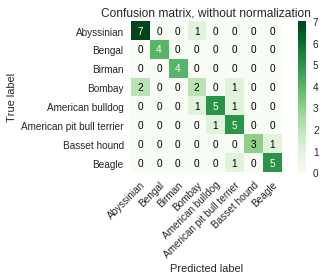

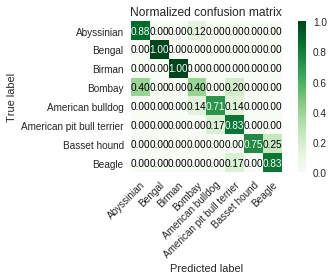

In [0]:
#@title Get confusion matrix of prediction
breedset = set(y_real)
all_breeds = list(breedset)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_real, y_pred, classes = all_breeds, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_real, y_pred,classes = all_breeds, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
#@title Result of other metrics like Precision, Recall, F1-score etc.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
description = 'Resnet50 trained for 8 dog/cat breeds'
precision = precision_score(y_pred, y_real, average='macro')
recall = recall_score(y_pred, y_real, average='macro')
accuracy = accuracy_score(y_pred, y_real)
f1 = fbeta_score(y_pred, y_real, 1, average='macro') #1 means f_1 measure
print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
print(classification_report(y_pred, y_real, digits=3))

Classifier 'Resnet50 trained for 8 dog/cat breeds' has Acc=0.795 P=0.801 R=0.821 F1=0.805
              precision    recall  f1-score   support

           0      0.875     0.778     0.824         9
           1      1.000     1.000     1.000         4
           2      1.000     1.000     1.000         4
           3      0.400     0.500     0.444         4
           4      0.714     0.833     0.769         6
           5      0.833     0.625     0.714         8
           6      0.750     1.000     0.857         3
           7      0.833     0.833     0.833         6

   micro avg      0.795     0.795     0.795        44
   macro avg      0.801     0.821     0.805        44
weighted avg      0.811     0.795     0.798        44



The confusion matrix used gives a summarised view of the model in a concise manner from which it is easy to interpret the information provided. As seen from the normalised confusion matrix, the model has a very high accuracy for predicting the breeds of Bengal cats and Birman cats as these have distinct features. Bengal cats are always black and Birman cats are usually light coloured. It is weakest when predicting the Abyssinian cat which it often mislabels as a Bombay cat and vise-versa. For its confusion with Bombay, it is unclear as Bombay has a black fur whereas Abyssinian has a bright cream fur. This confusion could occur if the picture of a Bombay is taken in a very bright light causing its fur to reflect it and hence seem lightly coloured. The predictions for light coloured breeds is very good as compared to the dark coloured Bombay cats and shows that the model may have a weakness to the background light of the pictures.

As for the dog breeds, the classifier has very few cases where it mislabels the breeds. This is due to the variations in the build, colour of each of the breeds selected. The F1 score of the classifier is ~81% which is a very good score for the model.

Metrics like F1 measure, precision and recall are ideal for measuring the performance of a classification model. Sklearn provides such inbuilt metrics which give the performance of the graph for each of the breeds. This allows the one to see for which breeds or classes the model is failing and either provide more varied training data for that model or tune the hyperparameters more. The precision values give insight about the accuracy of the model whereas recall tends to give sensitivity information. This combines to give the user the F1 measure. As can be seen from the F1 measure, the classifier performs very well for all the classes except the third one which is Bombay cats. This problem can be rectified by supplying more images of Bombay cats to the model to increase its accuracy.

## Visualization of the convolution layers

For the purpose of visualisation of the filters in a convolution layer, the top two layers of the model are taken. These layers are res2a_branch2c, res2a_branch1.

In [0]:
# Code of visulaization of the convolution layers taken from Lab4 of Deep Learning.

from keras import backend as K
import matplotlib.pyplot as plt

layer_name = 'res2a_branch2c'
filter_index = 0

layer_output = model.get_layer(layer_name).output
#layer_output.shape
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
# Add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1. 
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

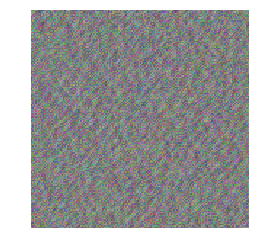

In [0]:
plt.imshow(generate_pattern('res2a_branch2c', 0))
plt.axis('off')
plt.show()

res2a_branch2c


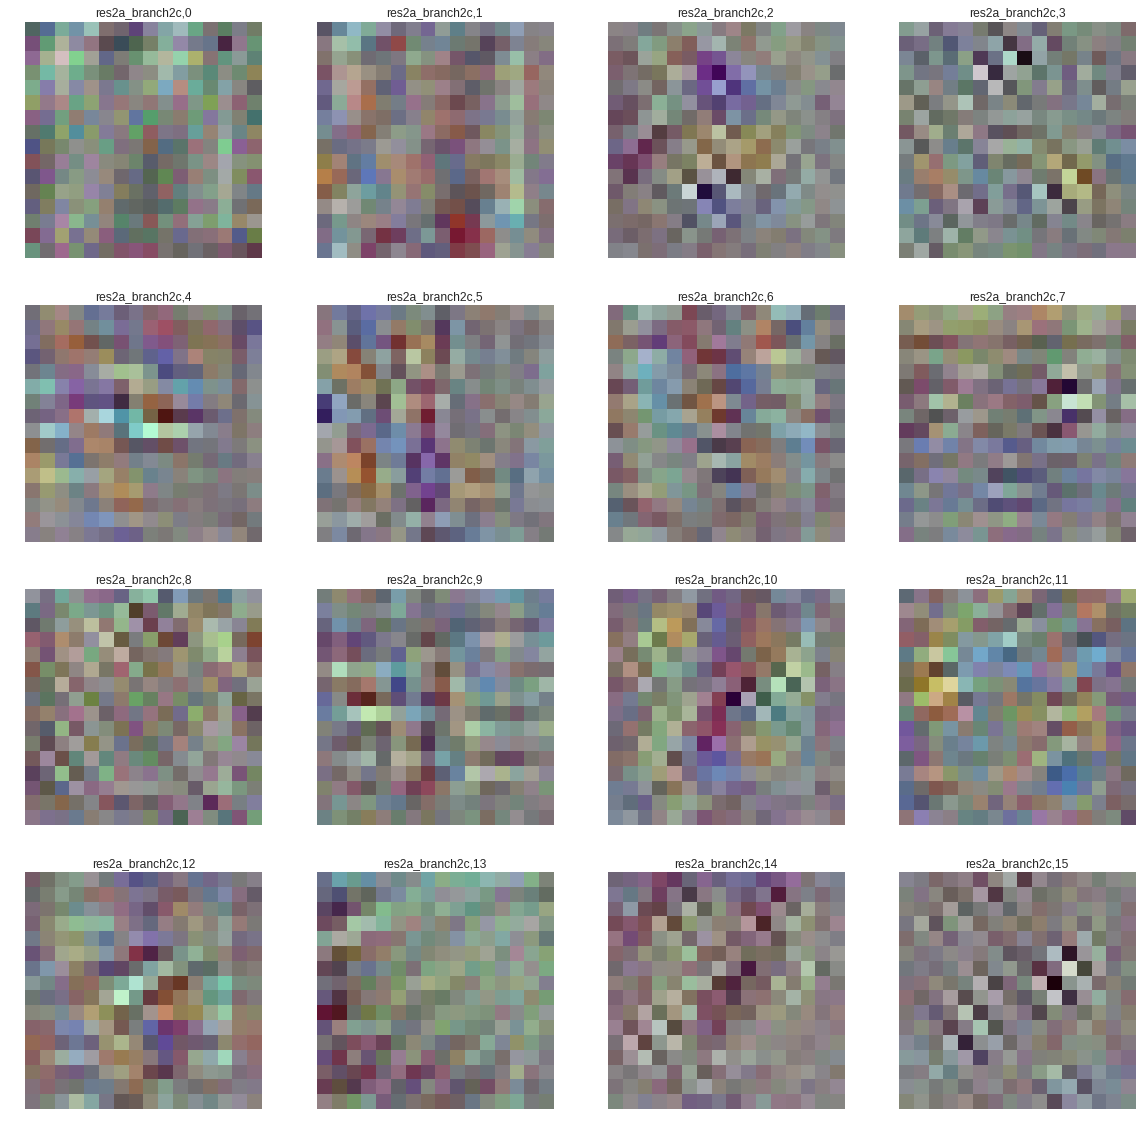

res2a_branch1


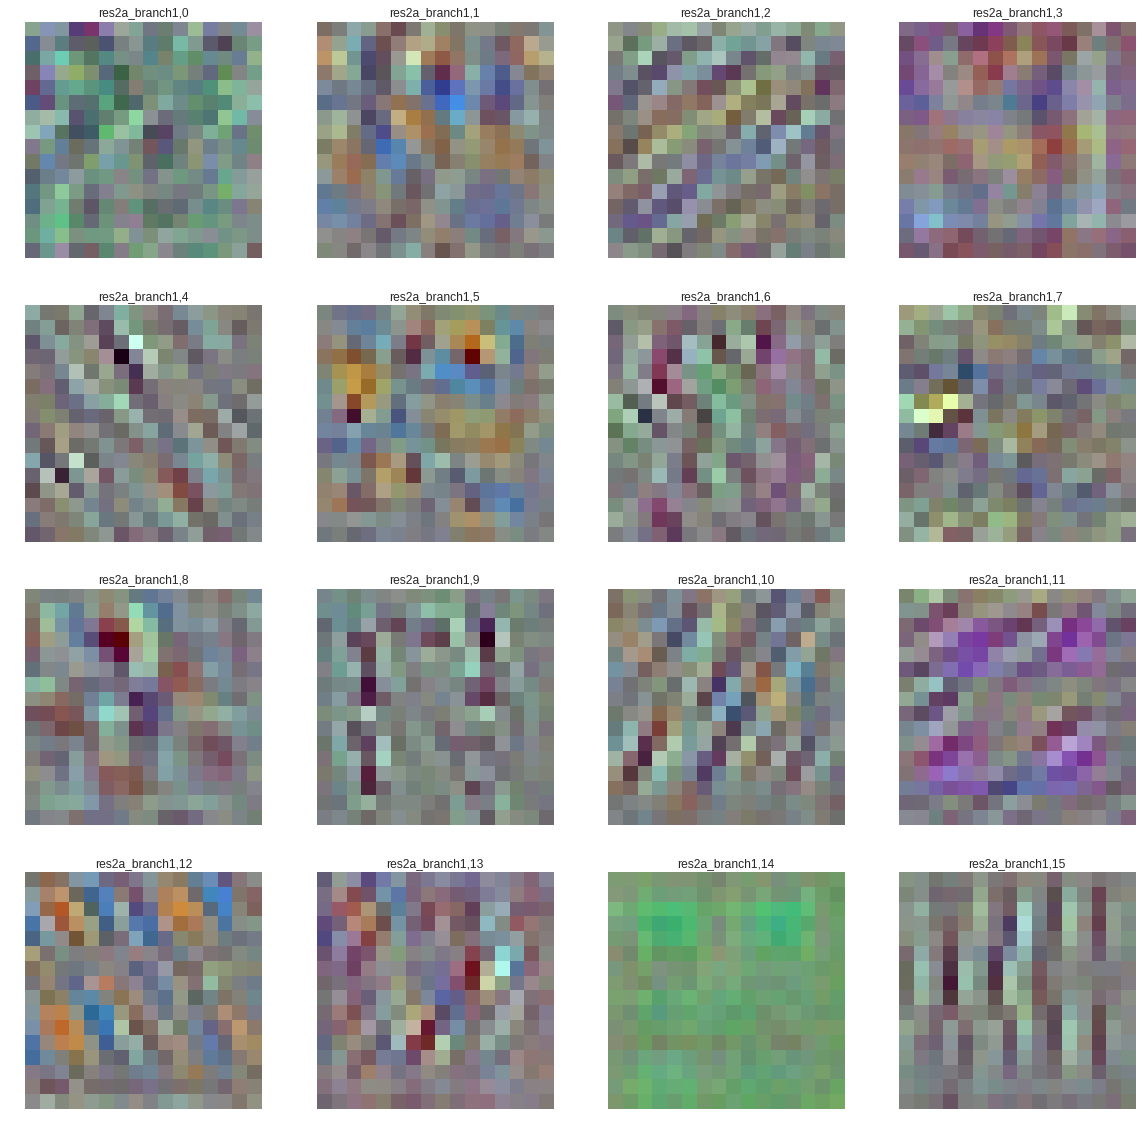

In [0]:
for layer_name in ['res2a_branch2c', 'res2a_branch1']:
    size = 16
    margin = 5

    # This an empty (black) image where we will store our results.
    results = np.zeros((4 * size + 7 * margin, 4 * size + 7 * margin, 3))

        
    plt.figure(figsize=(20,20))
    print(layer_name)
    for i in range(4):  # iterate over the rows of our results grid
        for j in range(4):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 4), size=size)
            ax = plt.subplot(4,4,j*4+i+1, frameon=False)
            ax.imshow(filter_img)
            plt.title(layer_name+','+str(j*4+i))
            plt.axis('off')
            
   
    plt.show()

The visualizations show the filters applied to each of the images through the convolution layers. A heatmap for an image can also be used for visualization and was attempted for this exercise but resulted in an empty graph and hence could not be pursued further.

## Conclusion

The classifier created gives a very good performance for the given data set. It shows that it can differentiate between not only the species of the image subject but also the breed. In comparison to the other metrics used, it was found that for Resnet50, other than ensuring the size of the image is 224, no other data augmentation was required. The pre-existing image preprocessor method allows the developer to focus on the hyperparameter of the classifier rather than the image generator. The optimizer RMSProp has shown to give a better performance than other optimizers. The Model is also scalable to include an increased number of classes. The confusion matrix shows that the error and success rate of the model is very good for certain breeds but not for others. Perhaps increasing the input data size may decrease this problem.

But the model does face some limitations as of now. For some breeds, especially cat breeds, the model has a higher rate of mislabels. This may be due to the fact that the structure most cat breeds are the same. The only defining features are usually the colour of their fur. In case of dim or very bright lighting conditions, the model may not be able to distinguish between the breed. This would cause a problem especially if a mobile application is built around this model. If the application is used outside in bright sunlight, a Bombay cat which has a black pelt may be confused for a Bengal or Abyssinian cat which has a lighter fur due to reflection. The opposite results may be found if the application is used in dimly lit rooms where the light coloured fur of some breeds may appear dark. There are chances that this may affect dog breeds as well. For example, a Pitbull may be mistaken for a BullDog due to their similar build as the colour of the fur cannot be used to recognise these dog breeds.

The final network developed can be enhanced to identify more breeds of cats and dogs without a significant impact on the accuracy of the model. It can further be improved to identify not just cat and dog breeds but breeds of other animals. As with cats and dogs, these animals selected would need some distinct differences like colour, structure, size etc between each breed so that the model is able to identify the differences them and learn from it.